# Long Names, Short Names
> How long is long? How short is short?

## Description

This notebook was created to look at the length of location names,
since they can take up a lot of space and it influences/affects how
the information is displayed on a web site. The ultimate goal is to
seeing what can be done to shorten them.

NOTE: Based on this analysis, the name of a Location is stored as two
attributes, 'name' for the processed/shortened name and 'original' for
the name loaded from the API. When a Location is added Django's pre-save
signal is used to clean the original name and save it in the 'name' attribute.

In [1]:
from django.db import connection
from django.db.models.functions import Length

from IPython.display import display, HTML

import matplotlib.pyplot as plt
import tabulate

from ebird.api.data.models import Location

In [34]:
# Find the twenty shortest names
locations = Location.objects.annotate(length=Length("original")).order_by("length")[:20]
names = [location.original for location in locations]

print("\n".join(names))

H
g
P
🌊
Cx
8F
7D
9H
9D
9F
5K
T3
6G
2M
9G
P1
9J
9I
5J
8E


In [38]:
# Find the twenty longest names
locations = Location.objects.annotate(length=Length('original')).order_by("-length")[:20]
names = [location.original for location in locations]
formatted = "<small>%s</small>" % "<br>".join(names)
display(HTML(formatted))

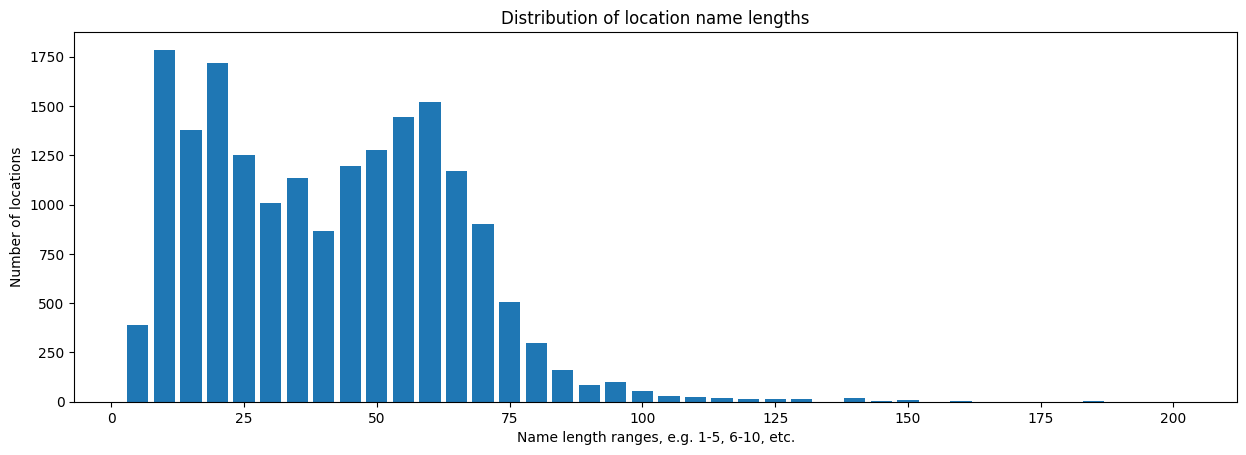

In [4]:
# What is the distribution of the name lengths?
with connection.cursor() as cursor:
    cursor.execute(
        "select count(*), ((length(original) - 1) / 5)::int as quantile from data_location group by quantile"
    )
    result = sorted(cursor.fetchall(), key=lambda t: t[1])

data: list[int] = []
labels: list[str] = []

for count, index in result:
    start = index * 5 + 1
    end = start + 4
    data.append(count)
    labels.append(end)

fig, ax = plt.subplots()
fig.set_figwidth(15)
ax.bar(labels, data, width=4)
ax.set_xlabel("Name length ranges, e.g. 1-5, 6-10, etc.")
ax.set_ylabel("Number of locations")
ax.set_title('Distribution of location name lengths')
plt.show();

In [ ]:
# Show the distribution in a table.

total = Location.objects.all().count()

labels = ["<=20", "21-40", "41-60", "61-80", "81-100", "101-120", ">120"]

values = [
    Location.objects.annotate(length=Length('original')).filter(length__lte=20).count(),
    Location.objects.annotate(length=Length('original')).filter(length__gt=20, length__lte=40).count(),
    Location.objects.annotate(length=Length('original')).filter(length__gt=40, length__lte=60).count(),
    Location.objects.annotate(length=Length('original')).filter(length__gt=60, length__lte=80).count(),
    Location.objects.annotate(length=Length('original')).filter(length__gt=80, length__lte=100).count(),
    Location.objects.annotate(length=Length('original')).filter(length__gt=100, length__lte=120).count(),
    Location.objects.annotate(length=Length('original')).filter(length__gt=120).count()
]

percentages = [round(value / total * 100, 1) for value in values]

data = zip(labels, values, percentages)

table = tabulate.tabulate(data, headers=["Length", "n", "%"], tablefmt='html')
table